# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [23]:
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Union

#tf.enable_v2_behavior()
print(tf.config.list_physical_devices('GPU'))

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data loading

In [24]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

# Model creation

In [25]:
#@test {"output": "ignore"}
from warnings import filters

# Build CNN teacher.
cnn_model = tf.keras.Sequential([tf.keras.layers.Conv2D(input_shape=(28,28,1), kernel_size=3, strides=1, filters=32, activation='relu', name='Conv1'),
                                tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1, name='MaxPool1'),
                                tf.keras.layers.Conv2D(kernel_size=3, strides=1, filters=64, activation='relu', name='Conv2'),
                                tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name='MaxPool2'),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(128, activation='relu'),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(NUM_CLASSES)])
cnn_model.build()
cnn_model.summary()


# Build fully connected student.
fc_model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(28,28,1)),
                                tf.keras.layers.Dense(784, activation='relu'),
                                tf.keras.layers.Dense(784, activation='relu'),
                                tf.keras.layers.Dense(NUM_CLASSES)])
fc_model.build()
fc_model.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 25, 25, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 23, 23, 64)        18496     
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7744)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

# Teacher loss function

In [26]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits)


  return cross_entropy_loss_value

# Student loss function

In [27]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
  # your code start from here for step 3
  # softmax modified with temperature for teacher logits
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  #print("Using temperature: " + str(DISTILLATION_TEMPERATURE))
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits)

  return (1 - ALPHA) * cross_entropy_loss_value + ALPHA * distillation_loss_value

# Train and evaluation

In [28]:
from email.mime import image


@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  best_accuracy = 0.0
  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        # your code start from here for step 4
        tape.watch(images) 
        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += tf.keras.backend.get_value(compute_num_correct(model, images, labels)[0])
    last_accuracy = num_correct / num_total * 100
    if last_accuracy > best_accuracy:
      best_accuracy = last_accuracy
    print("Class_accuracy: " + '{:.2f}%'.format(
        last_accuracy))
  return best_accuracy


# Training models

In [29]:
# your code start from here for step 5 
train_and_evaluate(cnn_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 98.25%
Epoch 2: Class_accuracy: 98.72%
Epoch 3: Class_accuracy: 98.72%
Epoch 4: Class_accuracy: 99.08%
Epoch 5: Class_accuracy: 98.94%
Epoch 6: Class_accuracy: 98.96%
Epoch 7: Class_accuracy: 99.06%
Epoch 8: Class_accuracy: 99.16%
Epoch 9: Class_accuracy: 99.17%
Epoch 10: Class_accuracy: 99.19%
Epoch 11: Class_accuracy: 99.18%
Epoch 12: Class_accuracy: 99.17%


99.19

In [34]:
#temperature 1 = {0.1: 98.14, 0.3: 98.52, 0.5: 98.43, 0.7: 98.41, 0.9: 98.39}
#temperature 4 = {0.1: 98.68, 0.3: 98.77, 0.5: 98.72, 0.7: 98.69, 0.9: 98.70}
#temperature 16= {0.1: 98.89, 0.3: 98.80, 0.5: 98.80, 0.7: 98.81, 0.9: 98.76}
#temperature 32= {0.1: 98.83, 0.3: 98.81, 0.5: 98.91, 0.7: 98.82, 0.9: 98.85}
#temperature 64= {0.1: 98.91, 0.3: 98.83, 0.5: 98.83, 0.7: 98.81, 0.9: 98.79}
test_reg_param = [0.1, 0.3, 0.5, 0.7, 0.9]
accuracy_results = dict()
for reg_param in test_reg_param:
    ALPHA = reg_param
    DISTILLATION_TEMPERATURE = 64
    print("Training student model with regularization parameter value " + str(ALPHA))
    fc_model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(28,28,1)),
                                tf.keras.layers.Dense(784, activation='relu'),
                                tf.keras.layers.Dense(784, activation='relu'),
                                tf.keras.layers.Dense(NUM_CLASSES)])
    fc_model.build()
    accuracy = train_and_evaluate(fc_model, compute_student_loss)
    accuracy_results[reg_param] = accuracy
print(accuracy_results)

Training student model with regularization parameter value 0.1
Epoch 1: Class_accuracy: 97.06%
Epoch 2: Class_accuracy: 97.86%
Epoch 3: Class_accuracy: 98.28%
Epoch 4: Class_accuracy: 98.45%
Epoch 5: Class_accuracy: 98.51%
Epoch 6: Class_accuracy: 98.67%
Epoch 7: Class_accuracy: 98.65%
Epoch 8: Class_accuracy: 98.71%
Epoch 9: Class_accuracy: 98.76%
Epoch 10: Class_accuracy: 98.79%
Epoch 11: Class_accuracy: 98.85%
Epoch 12: Class_accuracy: 98.91%
Training student model with regularization parameter value 0.3
Epoch 1: Class_accuracy: 97.08%
Epoch 2: Class_accuracy: 97.99%
Epoch 3: Class_accuracy: 98.33%
Epoch 4: Class_accuracy: 98.46%
Epoch 5: Class_accuracy: 98.57%
Epoch 6: Class_accuracy: 98.64%
Epoch 7: Class_accuracy: 98.71%
Epoch 8: Class_accuracy: 98.62%
Epoch 9: Class_accuracy: 98.81%
Epoch 10: Class_accuracy: 98.73%
Epoch 11: Class_accuracy: 98.84%
Epoch 12: Class_accuracy: 98.80%
Training student model with regularization parameter value 0.5
Epoch 1: Class_accuracy: 96.83%
Epoch

In [21]:
test_temperatures = [1, 2, 4, 16, 32, 64]
accuracy_results = dict()
for temperature in test_temperatures:
    DISTILLATION_TEMPERATURE = temperature
    print("Training student model with temperature " + str(DISTILLATION_TEMPERATURE))
    fc_model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(28,28,1)),
                                tf.keras.layers.Dense(784, activation='relu'),
                                tf.keras.layers.Dense(784, activation='relu'),
                                tf.keras.layers.Dense(NUM_CLASSES)])
    fc_model.build()
    accuracy = train_and_evaluate(fc_model, compute_student_loss)
    accuracy_results[temperature] = accuracy
print(accuracy_results)

Training student model with temperature 1
Epoch 1: Class_accuracy: 96.82%
Epoch 2: Class_accuracy: 97.23%
Epoch 3: Class_accuracy: 98.01%
Epoch 4: Class_accuracy: 97.97%
Epoch 5: Class_accuracy: 98.08%
Epoch 6: Class_accuracy: 98.00%
Epoch 7: Class_accuracy: 98.13%
Epoch 8: Class_accuracy: 98.14%
Epoch 9: Class_accuracy: 98.07%
Epoch 10: Class_accuracy: 98.36%
Epoch 11: Class_accuracy: 98.17%
Epoch 12: Class_accuracy: 98.30%
Training student model with temperature 2
Epoch 1: Class_accuracy: 96.55%
Epoch 2: Class_accuracy: 97.44%
Epoch 3: Class_accuracy: 97.97%
Epoch 4: Class_accuracy: 98.05%
Epoch 5: Class_accuracy: 98.39%
Epoch 6: Class_accuracy: 98.35%
Epoch 7: Class_accuracy: 98.41%
Epoch 8: Class_accuracy: 98.49%
Epoch 9: Class_accuracy: 98.52%
Epoch 10: Class_accuracy: 98.50%
Epoch 11: Class_accuracy: 98.58%
Epoch 12: Class_accuracy: 98.47%
Training student model with temperature 4
Epoch 1: Class_accuracy: 96.75%
Epoch 2: Class_accuracy: 97.98%
Epoch 3: Class_accuracy: 98.36%
Epoc

# Test accuracy vs. tempreture curve

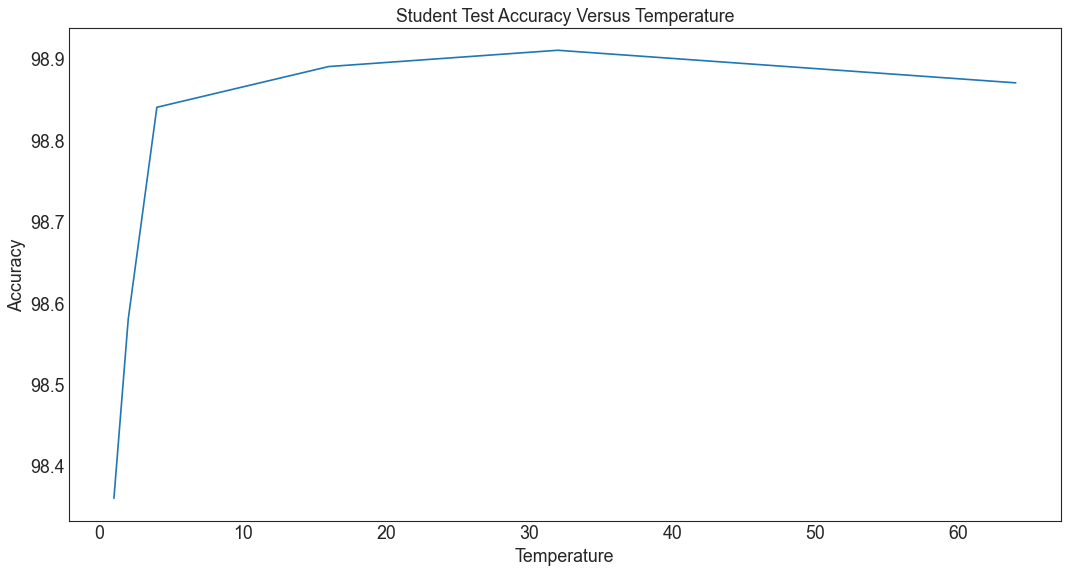

In [16]:
# your code start from here for step 6
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import seaborn as sns

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
            'legend.fontsize': large,
            'figure.figsize': (16, 10),
            'axes.labelsize': med,
            'axes.titlesize': med,
            'xtick.labelsize': med,
            'ytick.labelsize': med,
            'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(16,8), dpi=80)

test_temperatures = [1, 2, 4, 16, 32, 64]
accuracy_results = {1: 98.36, 2: 98.58, 4: 98.83999999999999, 16: 98.89, 32: 98.91, 64: 98.87}

x = np.array(test_temperatures)
accuracy_value_results = []
for temp in test_temperatures:
    accuracy_value_results.append(accuracy_results[temp])
y = np.array(accuracy_value_results)

plt.plot(x, y)
plt.title("Student Test Accuracy Versus Temperature")
plt.xlabel("Temperature")
plt.ylabel("Accuracy")
plt.savefig("temperature_vs_accuracy.svg", format="svg")
plt.show()

# Alpha versus Accuracy versus Temperature

<Figure size 1600x1000 with 0 Axes>

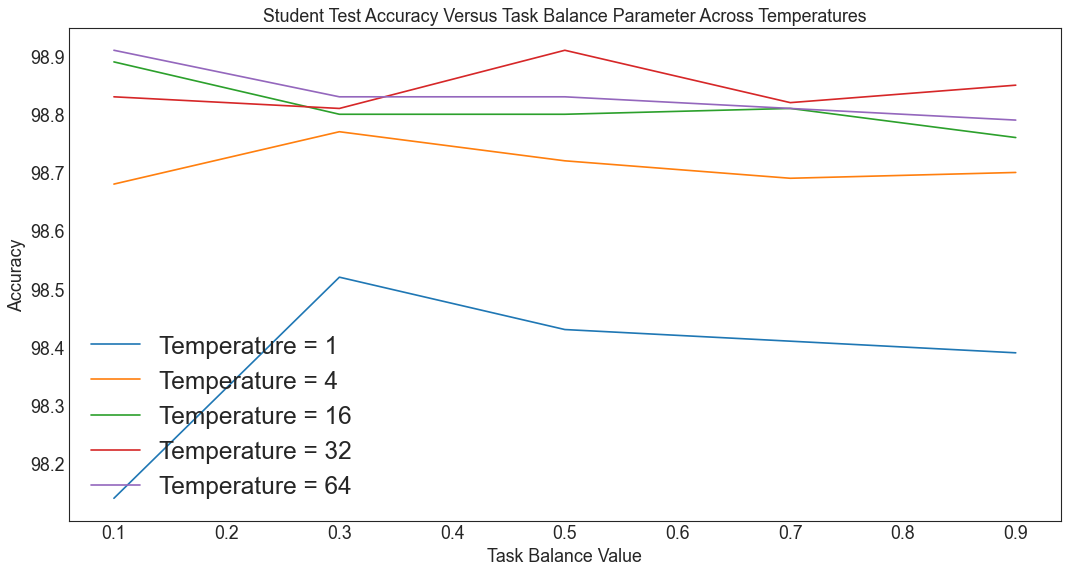

In [38]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
            'legend.fontsize': large,
            'figure.figsize': (16, 10),
            'axes.labelsize': med,
            'axes.titlesize': med,
            'xtick.labelsize': med,
            'ytick.labelsize': med,
            'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.figure(figsize=(16,8), dpi=80)

test_reg_param = [0.1, 0.3, 0.5, 0.7, 0.9]
temperature_1 = [98.14, 98.52, 98.43, 98.41, 98.39]
temperature_4 = [98.68, 98.77, 98.72, 98.69, 98.70]
temperature_16 = [98.89, 98.80, 98.80, 98.81, 98.76]
temperature_32 = [98.83, 98.81, 98.91, 98.82, 98.85]
temperature_64 = [98.91, 98.83, 98.83, 98.81, 98.79]

x = np.array(test_reg_param)
y_1 = np.array(temperature_1)
y_4 = np.array(temperature_4)
y_16 = np.array(temperature_16)
y_32 = np.array(temperature_32)
y_64 = np.array(temperature_64)

plt.title("Student Test Accuracy Versus Task Balance Parameter Across Temperatures")
plt.xlabel("Task Balance Value")
plt.ylabel("Accuracy")
plt.plot(x, y_1, label = "Temperature = 1")
plt.plot(x, y_4, label = "Temperature = 4")
plt.plot(x, y_16, label = "Temperature = 16")
plt.plot(x, y_32, label = "Temperature = 32")
plt.plot(x, y_64, label = "Temperature = 64")
plt.legend()
plt.savefig("task_balance_vs_accuracy.svg", format="svg")
plt.show()

# Train student from scratch

In [17]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(28,28,1)),
                                                tf.keras.layers.Dense(784, activation='relu'),
                                                tf.keras.layers.Dense(784, activation='relu'),
                                                tf.keras.layers.Dense(NUM_CLASSES)])

# your code start from here for step 7



#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits)
  
  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.55%
Epoch 2: Class_accuracy: 97.43%
Epoch 3: Class_accuracy: 97.91%
Epoch 4: Class_accuracy: 97.63%
Epoch 5: Class_accuracy: 97.87%
Epoch 6: Class_accuracy: 98.17%
Epoch 7: Class_accuracy: 98.19%
Epoch 8: Class_accuracy: 97.96%
Epoch 9: Class_accuracy: 98.34%
Epoch 10: Class_accuracy: 98.18%
Epoch 11: Class_accuracy: 98.22%
Epoch 12: Class_accuracy: 98.03%


98.34

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [22]:
# your code start from here for step 8
from keras_flops import get_flops
flops_teacher = get_flops(cnn_model, batch_size=BATCH_SIZE)
flops_student = get_flops(fc_model, batch_size=BATCH_SIZE)
print("The number of FLOPs for the teacher model for a batch size of " + str(BATCH_SIZE) + "is: " + str(flops_teacher))
print("The number of FLOPs for the student model for a batch size of " + str(BATCH_SIZE) + "is: " + str(flops_student))
print("This means that the teacher model is " + str(float(flops_teacher) / flops_student) + "x times computationally more expensive than the student model.")

trainable_params_teacher = np.sum([np.prod(v.get_shape()) for v in cnn_model.trainable_weights]) # formula learnt from: https://lindevs.com/count-number-of-parameters-of-model-in-tensorflow-2
nontrainable_params_teacher = np.sum([np.prod(v.get_shape()) for v in cnn_model.non_trainable_weights]) # formula learnt from: https://lindevs.com/count-number-of-parameters-of-model-in-tensorflow-2
total_params_teacher = trainable_params_teacher + nontrainable_params_teacher

trainable_params_student = np.sum([np.prod(v.get_shape()) for v in fc_model.trainable_weights])
nontrainable_params_student = np.sum([np.prod(v.get_shape()) for v in fc_model.non_trainable_weights])
total_params_student = trainable_params_student + nontrainable_params_student

print("The number of parameters in the teacher model is: " + str(total_params_teacher))
print("The number of parameters in the student model is: " + str(total_params_student))
print("This means that the teacher model is " + str(float(total_params_teacher) / total_params_student) + "x times larger than the student model.")
print("This in turn means that while in terms of parameters the teacher model is smaller than the student model, it is much more computationally expensive.")

The number of FLOPs for the teacher model for a batch size of 256is: 5642766848
The number of FLOPs for the student model for a batch size of 256is: 633825792
This means that the teacher model is 8.902709418300226x times computationally more expensive than the student model.
The number of parameters in the teacher model is: 1011466.0
The number of parameters in the student model is: 1238730.0
This means that the teacher model is 0.816534676644628x times larger than the student model.
This in turn means that while in terms of parameters the teacher model is smaller than the student model, it is much more computationally expensive.


# Implementing the state-of-the-art KD algorithm

In [40]:
# your code start from here for step 12
#@test {"output": "ignore"}
from warnings import filters

# Build CNN teacher.
cnn_model = tf.keras.Sequential([tf.keras.layers.Conv2D(input_shape=(28,28,1), kernel_size=3, strides=1, filters=32, activation='relu', name='Conv1'),
                                tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1, name='MaxPool1'),
                                tf.keras.layers.Conv2D(kernel_size=3, strides=1, filters=64, activation='relu', name='Conv2'),
                                tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name='MaxPool2'),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(128, activation='relu'),
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(NUM_CLASSES)])
cnn_model.build()
cnn_model.summary()


# Build fully connected student.
fc_model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(28,28,1)),
                                tf.keras.layers.Dense(784, activation='relu'),
                                tf.keras.layers.Dense(784, activation='relu'),
                                tf.keras.layers.Dense(NUM_CLASSES)])
fc_model.build()
fc_model.summary()

# Hyperparameters for distillation (need to be tuned).
BETA = 7.2 # task balance between cross-entropy and distillation loss
GAMMA = 0.1
TEACHER_TEMPERATURE = 4 # teacher temperature hyperparameter
STUDENT_TEMPERATURE = 1 # student temperature hyperparameter
LABEL_SMOOTHING_PARAMETER = 0.2 # label parameter similar as the parameter used in label smoothing

@tf.function
def compute_teacher_loss_new_method(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits)


  return cross_entropy_loss_value

def distillation_loss_new_method(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
  # calculate uniform probability
  u_prob = 1 / NUM_CLASSES

  # calculate teacher class probabilities
  p_t = tf.nn.softmax(teacher_logits / TEACHER_TEMPERATURE)

  # calculate teacher probability deviations from uniform probability
  prob_deviation = p_t - u_prob

  # max between probability deviations and 0 to get distinctive deviations
  distinct_prob_teacher = tf.nn.relu(prob_deviation)

  # calculate magnitude of output tensor
  tensor_numpy = tf.make_ndarray(distinct_prob_teacher)
  p_distinct_t_magnitude = np.sqrt(tensor_numpy.dot(tensor_numpy))

  # merge into teacher annotation
  q_t = (1 - LABEL_SMOOTHING_PARAMETER) * (prob_deviation / p_distinct_t_magnitude) + LABEL_SMOOTHING_PARAMETER * u_prob

  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(q_t, student_logits / STUDENT_TEMPERATURE))

def compute_student_loss_new_method(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  #print("Using temperature: " + str(DISTILLATION_TEMPERATURE))
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits)

  return GAMMA * cross_entropy_loss_value + BETA * distillation_loss_value

teacher_accuracy = train_and_evaluate(cnn_model, compute_teacher_loss_new_method)
student_accuracy = train_and_evaluate(fc_model, compute_student_loss_new_method)
print("Teacher best accuracy was: " + str(teacher_accuracy))
print("Student best accuracy with novel method was: " + str(student_accuracy))

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 25, 25, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 23, 23, 64)        18496     
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 7744)              0         
_________________________________________________________________
dense_93 (Dense)             (None, 128)             

# (Optional) XAI method to explain models

In [ ]:
# your code start from here for step 13
